# Technical Notebook

## Project Overview

who are the stakeholders?

Covid-19 has pushed many business online that may have not had a strong online presence. Pivoting

write about e-commerce impact from recommendations.

Book-recommender system is a proof of concept to encourage the new busnisses that have launched online to incorporate a rating and recommender system.



## Data Understanding

In this section you will find...




#### Obtaining the Data

Explain web-scrapping process for reproducibility.

Where to find the functions, how to do it. why did it?

#### Data Properties

How relates to the real world problem.

explain what features the dataset has, which ones will be used for this phase of the project. 

Write about how want to have a good recommendation because want customers to trust the recommendation system so that they continue to use it in the future. 

## Data Preparation and Exploratory Data Analysis

In this section you will find...

#### Import Libraries

The following cell has the libraries needed to perform the operations in this notebook

In [2]:
import pandas as pd

import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns


import os

from sklearn.preprocessing import LabelEncoder

In [6]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.recommendation import ALS

from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pyspark

from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.types import *

#### Import Dataset

As mentioned in the previous section, this dataset is a combination of the multiple tables that were exported during the web scrapping process. 

In [2]:
df = pd.read_csv('../../data/final/comb_df.csv')

#### Inspect Dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157332 entries, 0 to 157331
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             157332 non-null  object 
 1   title             157332 non-null  object 
 2   author            157332 non-null  object 
 3   pages             157332 non-null  object 
 4   unique_key        157332 non-null  object 
 5   average_rating    157332 non-null  float64
 6   book_description  109970 non-null  object 
 7   user_name         157332 non-null  object 
 8   user_unique_key   157332 non-null  object 
 9   number_of_stars   157332 non-null  int64  
 10  book_unique_key   157332 non-null  object 
 11  review_text       154800 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 14.4+ MB


In [4]:
df.head()

,genre,title,author,pages,unique_key,average_rating,book_description,user_name,user_unique_key,number_of_stars,book_unique_key,review_text
0,short-stories,The Neil Gaiman Reader: Selected Fiction,by Neil Gaiman (Goodreads Author),752 pages,https://www.goodreads.com/book/show/50358085-t...,4.54,An outstanding array—52 pieces in all—of selec...,Kayla Brown,https://www.goodreads.com/user/show/33397902-k...,5,https://www.goodreads.com/book/show/50358085-t...,NaN
1,short-stories,The Neil Gaiman Reader: Selected Fiction,by Neil Gaiman (Goodreads Author),752 pages,https://www.goodreads.com/book/show/50358085-t...,4.54,An outstanding array—52 pieces in all—of selec...,Dan Trefethen,https://www.goodreads.com/user/show/90604449-d...,5,https://www.goodreads.com/book/show/50358085-t...,There are two types of readers in this world:\...
2,short-stories,The Neil Gaiman Reader: Selected Fiction,by Neil Gaiman (Goodreads Author),752 pages,https://www.goodreads.com/book/show/50358085-t...,4.54,An outstanding array—52 pieces in all—of selec...,Jamie (TheRebelliousReader),https://www.goodreads.com/user/show/7515832-ja...,0,https://www.goodreads.com/book/show/50358085-t...,I need this more than I think I've ever needed...
3,short-stories,The Neil Gaiman Reader: Selected Fiction,by Neil Gaiman (Goodreads Author),752 pages,https://www.goodreads.com/book/show/50358085-t...,4.54,An outstanding array—52 pieces in all—of selec...,Adam Di Filippe,https://www.goodreads.com/user/show/5907077-ad...,5,https://www.goodreads.com/book/show/50358085-t...,"I received a free, advanced copy from NetGalle..."
4,short-stories,The Neil Gaiman Reader: Selected Fiction,by Neil Gaiman (Goodreads Author),752 pages,https://www.goodreads.com/book/show/50358085-t...,4.54,An outstanding array—52 pieces in all—of selec...,Morgan,https://www.goodreads.com/user/show/3433933-mo...,0,https://www.goodreads.com/book/show/50358085-t...,"This is a hefty read, but it’s one that can be..."


In [5]:
df.shape

(157332, 12)

In [6]:
df['book_unique_key'].nunique()

484

In [7]:
df['author'].nunique()

415

In [8]:
df['user_unique_key'].nunique()

28959

In [9]:
df['review_text'].nunique()

56058

In [11]:
df.duplicated(subset='user_unique_key',keep=False).sum()

143642

#### Data Preprocessing

Because my scrapper took reviews based on books found on a specific genre's page, there were duplicates between the book ratings because they may have been classified under multiple genres--such as one book falling into fiction, historical fiction, and history genres.

During the data cleaning process I:
- combined the multiple genre book and reviews table to make one combined data frame
- took out the duplicate data left by the scrapping
- removed extraneous text
- removed text in mixed data type columns, such as the word "pages" from the pages columns so that column could be an integer data type


EXPLAIN REASONING BEHIND EACH DECISION.

In [12]:
# replace book unique key link with unique numerical

enc = LabelEncoder()
enc.fit(df['book_unique_key'])
df['book_unique_key'] = enc.transform(df['book_unique_key'])
comb_df2 = df

In [13]:
comb_df2.tail()

,genre,title,author,pages,unique_key,average_rating,book_description,user_name,user_unique_key,number_of_stars,book_unique_key,review_text
157327,adventure,The Sea of Monsters,by Rick Riordan (Goodreads Author),279 pages,https://www.goodreads.com/book/show/28186.The_...,4.24,NaN,ｄａｎｉｅｌａ,https://www.goodreads.com/user/show/69098728,4,105,This was honestly so much fun! I enjoyed this ...
157328,adventure,The Sea of Monsters,by Rick Riordan (Goodreads Author),279 pages,https://www.goodreads.com/book/show/28186.The_...,4.24,NaN,Kyla Harris,https://www.goodreads.com/user/show/27881731-k...,4,105,Plot - 16/20\nCharacters - 16/20\nCreativity -...
157329,adventure,The Sea of Monsters,by Rick Riordan (Goodreads Author),279 pages,https://www.goodreads.com/book/show/28186.The_...,4.24,NaN,Sara,https://www.goodreads.com/user/show/69932312-sara,4,105,I love this Universe!\nThis is a really great ...
157330,adventure,The Sea of Monsters,by Rick Riordan (Goodreads Author),279 pages,https://www.goodreads.com/book/show/28186.The_...,4.24,NaN,Alaina,https://www.goodreads.com/user/show/50620706-a...,5,105,"“Powdered donuts,"" Tyson said earnestly. ""I wi..."
157331,adventure,The Sea of Monsters,by Rick Riordan (Goodreads Author),279 pages,https://www.goodreads.com/book/show/28186.The_...,4.24,NaN,Vanessa J.,https://www.goodreads.com/user/show/19590155-v...,3,105,"3.5 out of 5 stars\n\nDear Percy Jackson fans,..."


In [14]:
# replace user unique key link with unique numerical

enc = LabelEncoder()
enc.fit(comb_df2['user_unique_key'])
comb_df2['user_unique_key'] = enc.transform(comb_df2['user_unique_key'])
comb_df3 = comb_df2
comb_df3.head()

,genre,title,author,pages,unique_key,average_rating,book_description,user_name,user_unique_key,number_of_stars,book_unique_key,review_text
0,short-stories,The Neil Gaiman Reader: Selected Fiction,by Neil Gaiman (Goodreads Author),752 pages,https://www.goodreads.com/book/show/50358085-t...,4.54,An outstanding array—52 pieces in all—of selec...,Kayla Brown,12531,5,287,NaN
1,short-stories,The Neil Gaiman Reader: Selected Fiction,by Neil Gaiman (Goodreads Author),752 pages,https://www.goodreads.com/book/show/50358085-t...,4.54,An outstanding array—52 pieces in all—of selec...,Dan Trefethen,27474,5,287,There are two types of readers in this world:\...
2,short-stories,The Neil Gaiman Reader: Selected Fiction,by Neil Gaiman (Goodreads Author),752 pages,https://www.goodreads.com/book/show/50358085-t...,4.54,An outstanding array—52 pieces in all—of selec...,Jamie (TheRebelliousReader),24616,0,287,I need this more than I think I've ever needed...
3,short-stories,The Neil Gaiman Reader: Selected Fiction,by Neil Gaiman (Goodreads Author),752 pages,https://www.goodreads.com/book/show/50358085-t...,4.54,An outstanding array—52 pieces in all—of selec...,Adam Di Filippe,20526,5,287,"I received a free, advanced copy from NetGalle..."
4,short-stories,The Neil Gaiman Reader: Selected Fiction,by Neil Gaiman (Goodreads Author),752 pages,https://www.goodreads.com/book/show/50358085-t...,4.54,An outstanding array—52 pieces in all—of selec...,Morgan,12873,0,287,"This is a hefty read, but it’s one that can be..."


In [39]:
# remove extraneous text in author column

comb_df3['author'] = comb_df3['author'].replace({'by ': '', "(Goodreads Author)": ''}, regex=True)
comb_df4= comb_df3
comb_df4.head()

,genre,title,author,pages,unique_key,average_rating,book_description,user_name,user_unique_key,number_of_stars,book_unique_key,review_text
0,short-stories,The Neil Gaiman Reader: Selected Fiction,Neil Gaiman (),752,https://www.goodreads.com/book/show/50358085-t...,4.54,An outstanding array—52 pieces in all—of selec...,Kayla Brown,12531,5,287,NaN
1,short-stories,The Neil Gaiman Reader: Selected Fiction,Neil Gaiman (),752,https://www.goodreads.com/book/show/50358085-t...,4.54,An outstanding array—52 pieces in all—of selec...,Dan Trefethen,27474,5,287,There are two types of readers in this world:\...
2,short-stories,The Neil Gaiman Reader: Selected Fiction,Neil Gaiman (),752,https://www.goodreads.com/book/show/50358085-t...,4.54,An outstanding array—52 pieces in all—of selec...,Jamie (TheRebelliousReader),24616,0,287,I need this more than I think I've ever needed...
3,short-stories,The Neil Gaiman Reader: Selected Fiction,Neil Gaiman (),752,https://www.goodreads.com/book/show/50358085-t...,4.54,An outstanding array—52 pieces in all—of selec...,Adam Di Filippe,20526,5,287,"I received a free, advanced copy from NetGalle..."
4,short-stories,The Neil Gaiman Reader: Selected Fiction,Neil Gaiman (),752,https://www.goodreads.com/book/show/50358085-t...,4.54,An outstanding array—52 pieces in all—of selec...,Morgan,12873,0,287,"This is a hefty read, but it’s one that can be..."


In [17]:
# remove extraneous text in pages column

comb_df4['pages'] = comb_df4['pages'].replace({'pages': ''}, regex=True)
comb_df5= comb_df4
comb_df5.head()

,genre,title,author,pages,unique_key,average_rating,book_description,user_name,user_unique_key,number_of_stars,book_unique_key,review_text
0,short-stories,The Neil Gaiman Reader: Selected Fiction,Neil Gaiman (),752,https://www.goodreads.com/book/show/50358085-t...,4.54,An outstanding array—52 pieces in all—of selec...,Kayla Brown,12531,5,287,NaN
1,short-stories,The Neil Gaiman Reader: Selected Fiction,Neil Gaiman (),752,https://www.goodreads.com/book/show/50358085-t...,4.54,An outstanding array—52 pieces in all—of selec...,Dan Trefethen,27474,5,287,There are two types of readers in this world:\...
2,short-stories,The Neil Gaiman Reader: Selected Fiction,Neil Gaiman (),752,https://www.goodreads.com/book/show/50358085-t...,4.54,An outstanding array—52 pieces in all—of selec...,Jamie (TheRebelliousReader),24616,0,287,I need this more than I think I've ever needed...
3,short-stories,The Neil Gaiman Reader: Selected Fiction,Neil Gaiman (),752,https://www.goodreads.com/book/show/50358085-t...,4.54,An outstanding array—52 pieces in all—of selec...,Adam Di Filippe,20526,5,287,"I received a free, advanced copy from NetGalle..."
4,short-stories,The Neil Gaiman Reader: Selected Fiction,Neil Gaiman (),752,https://www.goodreads.com/book/show/50358085-t...,4.54,An outstanding array—52 pieces in all—of selec...,Morgan,12873,0,287,"This is a hefty read, but it’s one that can be..."


In [19]:
# remove unnessary columns
# dropping unique_key column because it is a duplicate of book unique key
# dropping user_name column because user_unique_key serves the same purpose and 
# addresses any similarities there may be within user names

comb_df6= comb_df5.drop(['unique_key', 'user_name'], axis= 1)
comb_df6.head() 


,genre,title,author,pages,average_rating,book_description,user_unique_key,number_of_stars,book_unique_key,review_text
0,short-stories,The Neil Gaiman Reader: Selected Fiction,Neil Gaiman (),752,4.54,An outstanding array—52 pieces in all—of selec...,12531,5,287,NaN
1,short-stories,The Neil Gaiman Reader: Selected Fiction,Neil Gaiman (),752,4.54,An outstanding array—52 pieces in all—of selec...,27474,5,287,There are two types of readers in this world:\...
2,short-stories,The Neil Gaiman Reader: Selected Fiction,Neil Gaiman (),752,4.54,An outstanding array—52 pieces in all—of selec...,24616,0,287,I need this more than I think I've ever needed...
3,short-stories,The Neil Gaiman Reader: Selected Fiction,Neil Gaiman (),752,4.54,An outstanding array—52 pieces in all—of selec...,20526,5,287,"I received a free, advanced copy from NetGalle..."
4,short-stories,The Neil Gaiman Reader: Selected Fiction,Neil Gaiman (),752,4.54,An outstanding array—52 pieces in all—of selec...,12873,0,287,"This is a hefty read, but it’s one that can be..."


In [30]:

comb_df7= comb_df6.drop_duplicates(subset=['user_unique_key', 'book_unique_key'], keep='first')
comb_df7.head()

,genre,title,author,pages,average_rating,book_description,user_unique_key,number_of_stars,book_unique_key,review_text
0,short-stories,The Neil Gaiman Reader: Selected Fiction,Neil Gaiman (),752,4.54,An outstanding array—52 pieces in all—of selec...,12531,5,287,NaN
1,short-stories,The Neil Gaiman Reader: Selected Fiction,Neil Gaiman (),752,4.54,An outstanding array—52 pieces in all—of selec...,27474,5,287,There are two types of readers in this world:\...
2,short-stories,The Neil Gaiman Reader: Selected Fiction,Neil Gaiman (),752,4.54,An outstanding array—52 pieces in all—of selec...,24616,0,287,I need this more than I think I've ever needed...
3,short-stories,The Neil Gaiman Reader: Selected Fiction,Neil Gaiman (),752,4.54,An outstanding array—52 pieces in all—of selec...,20526,5,287,"I received a free, advanced copy from NetGalle..."
4,short-stories,The Neil Gaiman Reader: Selected Fiction,Neil Gaiman (),752,4.54,An outstanding array—52 pieces in all—of selec...,12873,0,287,"This is a hefty read, but it’s one that can be..."


In [21]:
comb_df7.head()

,genre,title,author,pages,average_rating,book_description,user_unique_key,number_of_stars,book_unique_key,review_text
0,short-stories,The Neil Gaiman Reader: Selected Fiction,Neil Gaiman (),752,4.54,An outstanding array—52 pieces in all—of selec...,12531,5,287,NaN
1,short-stories,The Neil Gaiman Reader: Selected Fiction,Neil Gaiman (),752,4.54,An outstanding array—52 pieces in all—of selec...,27474,5,287,There are two types of readers in this world:\...
2,short-stories,The Neil Gaiman Reader: Selected Fiction,Neil Gaiman (),752,4.54,An outstanding array—52 pieces in all—of selec...,24616,0,287,I need this more than I think I've ever needed...
3,short-stories,The Neil Gaiman Reader: Selected Fiction,Neil Gaiman (),752,4.54,An outstanding array—52 pieces in all—of selec...,20526,5,287,"I received a free, advanced copy from NetGalle..."
4,short-stories,The Neil Gaiman Reader: Selected Fiction,Neil Gaiman (),752,4.54,An outstanding array—52 pieces in all—of selec...,12873,0,287,"This is a hefty read, but it’s one that can be..."


In [26]:
# remove ratings with "0" stars because these represent readers who wrote a review but did not give it a rating.
# for the moment, we are only interested in readers who gave it a rating. Ratings are from 1-5 stars.

comb_df8= comb_df7[comb_df7.number_of_stars != 0]

In [29]:
comb_df8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55079 entries, 0 to 157121
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genre             55079 non-null  object 
 1   title             55079 non-null  object 
 2   author            55079 non-null  object 
 3   pages             55079 non-null  object 
 4   average_rating    55079 non-null  float64
 5   book_description  41148 non-null  object 
 6   user_unique_key   55079 non-null  int64  
 7   number_of_stars   55079 non-null  int64  
 8   book_unique_key   55079 non-null  int64  
 9   review_text       54016 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 4.6+ MB


##### From the summary above we see that are some missing values in some of the columns. For this stage of the project, it is fine to leave them as is. For this first phase I am intersted in having a book_unique_key and number_of_stars that are not empty. If I were to remove the empty rows based on null values in book_description and review_text, I would lose rows wit valid data for this first phase.  Removing these missing values can be done during the second phase of the project when more data is added to the overall dataset.

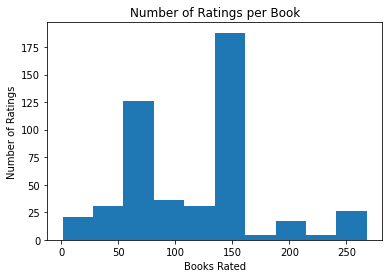

In [34]:
ratings_num=comb_df8.groupby('book_unique_key')['number_of_stars'].count().sort_values()

plt.hist(ratings_num);
plt.xlabel('Books Rated')
plt.ylabel('Number of Ratings')
plt.title('Number of Ratings per Book')
#plt.grid(True)
plt.show()

In [44]:
# saving cleaned data to import it into a spark dataframe for modeling
# could use dataframe without saving to external csv, but I wanted to save a copy of clean data for future processing

comb_df8.to_csv('../../data/final/comb_df_full.csv', index=False)


In [3]:
# small = df_pd[['user_unique_key', 'number_of_stars', 'book_unique_key']]
# small.to_csv('../../data/final/comb_df_sm.csv', index=False)

## Modeling

During the modeling process...

EXPLAIN pyspark ALS


In [7]:
spark = SparkSession.builder.master('local[*]').appName('capstone').getOrCreate()

In [4]:
df_pd= pd.read_csv('../../data/final/comb_df_clean.csv')


In [8]:
# setting a schema to let spark know what data types to import the columns as from the csv

schema = StructType([StructField("genre", StringType(), True),StructField("title", StringType(), True), 
                     StructField("author", StringType(), True), StructField("pages", IntegerType(), True), 
                     StructField("average_rating", FloatType(), True), StructField("book_description", StringType(), True), 
                     StructField("user_unique_key", IntegerType(), True),StructField("number_of_stars", IntegerType(), True), 
                     StructField("book_unique_key", IntegerType(), True), StructField("review_text", StringType(), True)])

df_sp = spark.createDataFrame(df_pd, schema=schema)

In [3]:
# df_pd= pd.read_csv('../../data/final/comb_df_sm.csv')

In [4]:
# schema = StructType([StructField("user_unique_key", IntegerType(), True),StructField("number_of_stars", IntegerType(), True), 
#                       StructField("book_unique_key", IntegerType(), True)])

# df_sp = spark.createDataFrame(df_pd, schema=schema)

In [9]:
df_sp.printSchema()

root
 |-- genre: string (nullable = true)
 |-- title: string (nullable = true)
 |-- author: string (nullable = true)
 |-- pages: integer (nullable = true)
 |-- average_rating: float (nullable = true)
 |-- book_description: string (nullable = true)
 |-- user_unique_key: integer (nullable = true)
 |-- number_of_stars: integer (nullable = true)
 |-- book_unique_key: integer (nullable = true)
 |-- review_text: string (nullable = true)



SPARCITY:

In [5]:
stars_num= df_sp.select("number_of_stars").count()


users = df_sp.select("user_unique_key").distinct().count()
books = df_sp.select("book_unique_key").distinct().count()


denominator = users * books


sparsity = (1.0 - (stars_num *1.0)/denominator)*100
print("The ratings dataframe is ", "%.2f" % sparsity + "% empty.")

The ratings dataframe is  99.60% empty.


In [11]:
train, test = df_sp.randomSplit([0.8, 0.2], seed= 2020)

#### First Simple Model(FSM)

In [12]:
als = ALS(userCol='user_unique_key', itemCol='book_unique_key', 
          ratingCol='number_of_stars',
          coldStartStrategy='drop')


model_fsm = als.fit(train)


In [13]:
predictions = model_fsm.transform(test)

In [14]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='number_of_stars',
                                predictionCol='prediction')
evaluator2 = RegressionEvaluator(metricName='mae', labelCol='number_of_stars',
                                predictionCol='prediction')

In [15]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='number_of_stars',
                                predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print('The RMSE is= ' + str(rmse))

The RMSE is= 1.5439266624623944


In [16]:
evaluator2 = RegressionEvaluator(metricName='mae', labelCol='number_of_stars',
                                predictionCol='prediction')
mae = evaluator2.evaluate(predictions)
print('The MAE is = ' + str(mae))

The MAE is = 1.191968248377123


In [17]:
als2 = ALS(maxIter=5,rank=4, 
          userCol='user_unique_key', itemCol='book_unique_key', 
          ratingCol='number_of_stars',
          coldStartStrategy='drop', seed= 2020)


model_2 = als2.fit(train)
predictions2 = model_2.transform(test)
predictions2.show()

+----------------+--------------------+-----------+-----+--------------+--------------------+---------------+---------------+---------------+--------------------+----------+
|           genre|               title|     author|pages|average_rating|    book_description|user_unique_key|number_of_stars|book_unique_key|         review_text|prediction|
+----------------+--------------------+-----------+-----+--------------+--------------------+---------------+---------------+---------------+--------------------+----------+
|biography-memoir|This Is Going to ...|Adam Kay ()|  256|          4.41|Welcome to the li...|           4799|              2|            148|DNF @ 40%

Standa...|  4.881459|
|biography-memoir|This Is Going to ...|Adam Kay ()|  256|          4.41|Welcome to the li...|          13665|              4|            148|I've worked with ...|-0.8096077|
|biography-memoir|This Is Going to ...|Adam Kay ()|  256|          4.41|Welcome to the li...|          16608|              5|     

In [18]:
rmse2 = evaluator.evaluate(predictions2)
print('The RMSE for Model 2 is= ' + str(rmse2))

The RMSE for Model 2 is= 2.192373988194588


In [19]:
mae2 = evaluator2.evaluate(predictions2)
print('The MAE for Model 2 is = ' + str(mae2))

The MAE for Model 2 is = 1.5325654366137673


Model 2 did worse than the first model. So I will try and put the numbers higher than the automatic values of 

In [20]:
als3 = ALS(maxIter=15,rank=10, 
          userCol='user_unique_key', itemCol='book_unique_key', 
          ratingCol='number_of_stars',
          coldStartStrategy='drop', seed= 2020)


model_3 = als3.fit(train)
predictions3 = model_3.transform(test)


In [21]:
rmse3 = evaluator.evaluate(predictions3)
print('The RMSE for Model 3 is= ' + str(rmse3))
mae3 = evaluator2.evaluate(predictions3)
print('The MAE for Model 3 is = ' + str(mae3))

The RMSE for Model 3 is= 1.3296583319458677
The MAE for Model 3 is = 1.0297928768718372


In [24]:
als4 = ALS(maxIter=15,rank=12, 
          userCol='user_unique_key', itemCol='book_unique_key', 
          ratingCol='number_of_stars',
          coldStartStrategy='drop', seed= 2020)


model_4 = als4.fit(train)
predictions4 = model_4.transform(test)

In [25]:
rmse4 = evaluator.evaluate(predictions4)
print('The RMSE for Model 4 is= ' + str(rmse4))
mae4 = evaluator2.evaluate(predictions4)
print('The MAE for Model 4 is = ' + str(mae4))

The RMSE for Model 4 is= 1.3299537069134824
The MAE for Model 4 is = 1.041297384551544


In [22]:
als5 = ALS(maxIter=20,rank=10, 
          userCol='user_unique_key', itemCol='book_unique_key', 
          ratingCol='number_of_stars',
          coldStartStrategy='drop', seed= 2020)

model_5 = als5.fit(train)
predictions5 = model_5.transform(test)

In [23]:
rmse5 = evaluator.evaluate(predictions5)
print('The RMSE for Model 5 is= ' + str(rmse5))
mae5 = evaluator2.evaluate(predictions5)
print('The MAE for Model 5 is = ' + str(mae5))

The RMSE for Model 5 is= 1.2502923712578855
The MAE for Model 5 is = 0.9725458899555556


In [26]:
type(als)

pyspark.ml.recommendation.ALS

In [28]:
(train, test) = df_sp.randomSplit([0.8, 0.2], seed= 2020)

In [29]:
als_model_reg = ALS(userCol='user_unique_key', itemCol='book_unique_key',ratingCol='number_of_stars',
                nonnegative=True,implicitPrefs=False, 
                coldStartStrategy='drop')



In [33]:
evaluator_reg = RegressionEvaluator(metricName='rmse', labelCol='number_of_stars',
                                predictionCol='prediction')

In [27]:
params=ParamGridBuilder()

In [30]:
# params = ParamGridBuilder().addGrid(als_model_reg.regParam, [0.01, .1, 1.5]).build()

In [39]:
params = ParamGridBuilder().addGrid(als_model_reg.regParam, [0.01, .1, 1.5]) \
        .addGrid(als_model_reg.rank, [4, 10, 30]) \
        .addGrid(als_model_reg.maxIter, [5, 15, 20]).build()
    


In [40]:
cv= CrossValidator()

In [41]:

cv = CrossValidator(estimator=als_model_reg, 
                          estimatorParamMaps=params,
                          evaluator=evaluator_reg,
                          numFolds= 5)

In [42]:
model=cv.fit(train)

In [43]:
best_model = model.bestModel

In [58]:
# Print the best parameters from the best model grid search and cross validation

print(" The best model Rank is: ", best_model._java_obj.parent().getRank())

print(" The best model MaxIter is:", best_model._java_obj.parent().getMaxIter())

print(" RegParam:", best_model._java_obj.parent().getRegParam())

 The best model Rank is:  30
 The best model MaxIter is: 20
  RegParam: 0.1


In [60]:
best_als= ALS(maxIter=20,rank=30, regParam=.1, 
          userCol='user_unique_key', itemCol='book_unique_key', 
          ratingCol='number_of_stars',
          coldStartStrategy='drop', seed= 2020)

model_best = best_als.fit(train)
predictions_best = model_best.transform(test)

In [61]:
rmse_evaluator = RegressionEvaluator(metricName='rmse', labelCol='number_of_stars',
                                predictionCol='prediction')
mae_evaluator = RegressionEvaluator(metricName='mae', labelCol='number_of_stars',
                                predictionCol='prediction')

In [62]:
rmse_best = rmse_evaluator.evaluate(predictions_best)
print('The RMSE for Model 5 is= ' + str(rmse_best))
mae_best = mae_evaluator.evaluate(predictions_best)
print('The MAE for Model 5 is = ' + str(mae_best))

The RMSE for Model 5 is= 1.2205628354495859
The MAE for Model 5 is = 0.9646155885877185


## Evaluation

Cross validation is....

in the context of the project it means...

In [ ]:
# close spark session

spark.stop()